NAME AND REG NO: ABDUL SUBHAN (FA23-BDS-061) MUHAMMAD IBRAHIM (FA23-BDS-062)

STEP 1 — DATA INGESTION & PREPROCESSING

In [ ]:
import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
!pip install mlxtend


Install & Import Libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Basic Cleaning

In [ ]:
df = pd.read_csv('data.csv', encoding='latin1')
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# Remove missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Remove cancelled invoices
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


Feature Engineering

In [ ]:
# Total Amount
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']


RFM FEATURE

In [ ]:
latest_date = df['InvoiceDate'].max()

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40


One-Hot Encoding Country

In [ ]:
country_encoded = pd.get_dummies(df[['CustomerID','Country']], columns=['Country'])
country_encoded = country_encoded.groupby('CustomerID').sum()

rfm = rfm.join(country_encoded, how='left').fillna(0)


Euclidean Distance (RFM)

In [ ]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

euclidean_dist = pairwise_distances(rfm_scaled, metric='euclidean')


Euclidean Heatmap

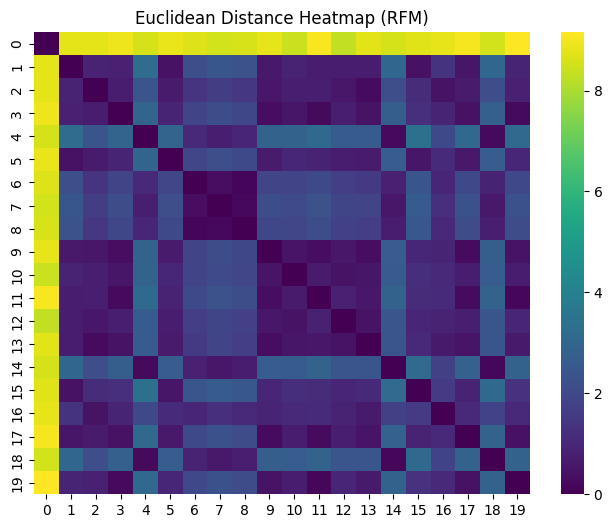

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(euclidean_dist[:20,:20], cmap='viridis')
plt.title("Euclidean Distance Heatmap (RFM)")
plt.show()


Jaccard Similarity (Top-10 Products)

In [ ]:
top_products = (
    df.groupby(['CustomerID','StockCode'])['Quantity']
      .sum()
      .reset_index()
)

top_products = top_products.sort_values(['CustomerID','Quantity'], ascending=False)
top_products = top_products.groupby('CustomerID').head(10)

customer_sets = top_products.groupby('CustomerID')['StockCode'].apply(set)

customers = customer_sets.index[:20]
jaccard_matrix = np.zeros((20,20))

for i, c1 in enumerate(customers):
    for j, c2 in enumerate(customers):
        intersection = len(customer_sets[c1] & customer_sets[c2])
        union = len(customer_sets[c1] | customer_sets[c2])
        jaccard_matrix[i,j] = intersection / union if union != 0 else 0


Jaccard Heatmap

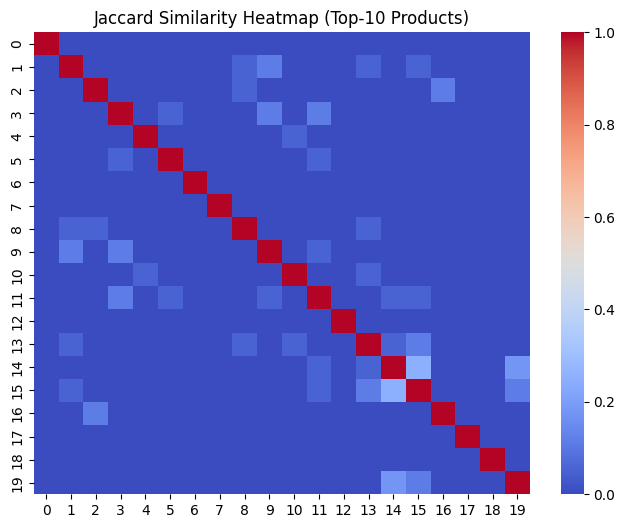

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(jaccard_matrix, cmap='coolwarm')
plt.title("Jaccard Similarity Heatmap (Top-10 Products)")
plt.show()


STEP 3 — CLUSTERING
 KMEANS

Elbow Method

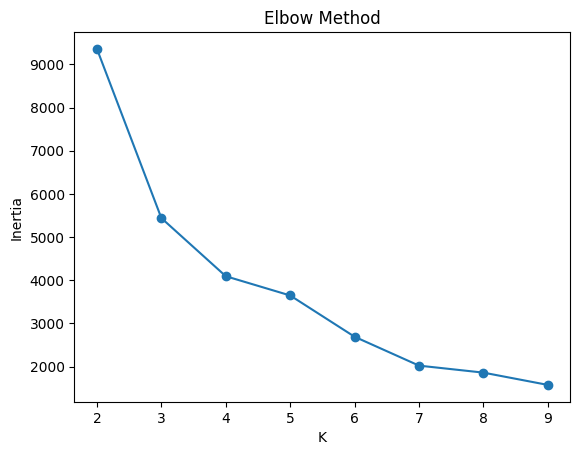

In [ ]:
inertia = []

for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2,10), inertia, marker='o')
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


KMeans Clustering

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['KMeansCluster'] = kmeans.fit_predict(rfm_scaled)


DBSCAN

In [ ]:
dbscan = DBSCAN(eps=0.8, min_samples=5)
rfm['DBSCANCluster'] = dbscan.fit_predict(rfm_scaled)


PCA Visualization

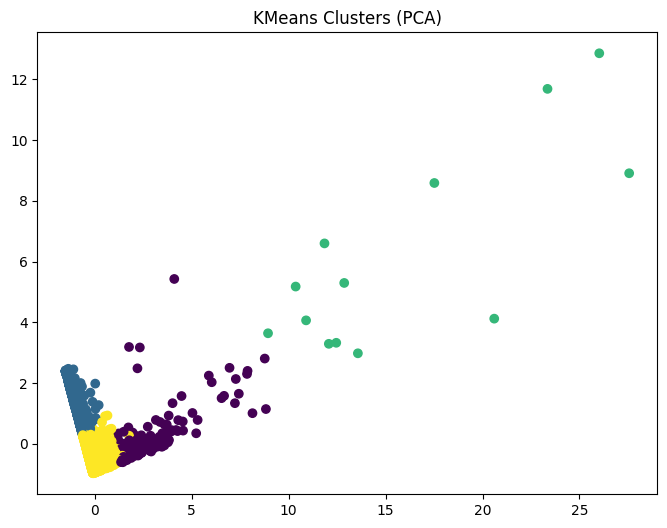

In [ ]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8,6))
plt.scatter(pca_data[:,0], pca_data[:,1], c=rfm['KMeansCluster'])
plt.title("KMeans Clusters (PCA)")
plt.show()


Basket Creation

In [ ]:
basket = df.groupby(['InvoiceNo','StockCode'])['Quantity'].sum().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)


Apriori

In [ ]:
start = pd.Timestamp.now()

freq_items = apriori(basket, min_support=0.02, use_colnames=True)
rules_ap = association_rules(freq_items, metric="confidence", min_threshold=0.6)
rules_ap = rules_ap[rules_ap['lift'] >= 1.2]

apriori_time = pd.Timestamp.now() - start
rules_ap.sort_values('lift', ascending=False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
19,(22698),"(22697, 22699)",0.029996,0.029186,0.021040,0.701439,24.033032,1.0,0.020165,3.251641,0.988027,0.551627,0.692463,0.711163
17,"(22697, 22699)",(22698),0.029186,0.029996,0.021040,0.720887,24.033032,1.0,0.020165,3.475313,0.987204,0.551627,0.712256,0.711163
18,"(22698, 22699)",(22697),0.023522,0.037279,0.021040,0.894495,23.994742,1.0,0.020163,9.124923,0.981409,0.529172,0.890410,0.729447
5,(22697),(22698),0.037279,0.029996,0.024817,0.665702,22.193256,1.0,0.023698,2.901615,0.991919,0.584498,0.655364,0.746520
6,(22698),(22697),0.029996,0.037279,0.024817,0.827338,22.193256,1.0,0.023698,5.575760,0.984471,0.584498,0.820652,0.746520
16,"(22697, 22698)",(22699),0.024817,0.042242,0.021040,0.847826,20.070631,1.0,0.019992,6.293837,0.974356,0.457210,0.841114,0.672955
9,(22698),(22699),0.029996,0.042242,0.023522,0.784173,18.563760,1.0,0.022255,4.437611,0.975389,0.482835,0.774654,0.670503
7,(22697),(22699),0.037279,0.042242,0.029186,0.782923,18.534184,1.0,0.027612,4.412071,0.982679,0.579850,0.773349,0.736928
8,(22699),(22697),0.042242,0.037279,0.029186,0.690932,18.534184,1.0,0.027612,3.114920,0.987771,0.579850,0.678964,0.736928
4,(22629),(22630),0.037980,0.033233,0.022874,0.602273,18.122934,1.0,0.021612,2.430729,0.982122,0.473214,0.588601,0.645292


FP-Growth

In [ ]:
start = pd.Timestamp.now()

freq_fp = fpgrowth(basket, min_support=0.02, use_colnames=True)
rules_fp = association_rules(freq_fp, metric="confidence", min_threshold=0.6)
rules_fp = rules_fp[rules_fp['lift'] >= 1.2]

fp_time = pd.Timestamp.now() - start
rules_fp.sort_values('lift', ascending=False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
15,"(22697, 22699)",(22698),0.029186,0.029996,0.021040,0.720887,24.033032,1.0,0.020165,3.475313,0.987204,0.551627,0.712256,0.711163
17,(22698),"(22697, 22699)",0.029996,0.029186,0.021040,0.701439,24.033032,1.0,0.020165,3.251641,0.988027,0.551627,0.692463,0.711163
16,"(22698, 22699)",(22697),0.023522,0.037279,0.021040,0.894495,23.994742,1.0,0.020163,9.124923,0.981409,0.529172,0.890410,0.729447
11,(22697),(22698),0.037279,0.029996,0.024817,0.665702,22.193256,1.0,0.023698,2.901615,0.991919,0.584498,0.655364,0.746520
12,(22698),(22697),0.029996,0.037279,0.024817,0.827338,22.193256,1.0,0.023698,5.575760,0.984471,0.584498,0.820652,0.746520
14,"(22697, 22698)",(22699),0.024817,0.042242,0.021040,0.847826,20.070631,1.0,0.019992,6.293837,0.974356,0.457210,0.841114,0.672955
13,(22698),(22699),0.029996,0.042242,0.023522,0.784173,18.563760,1.0,0.022255,4.437611,0.975389,0.482835,0.774654,0.670503
9,(22697),(22699),0.037279,0.042242,0.029186,0.782923,18.534184,1.0,0.027612,4.412071,0.982679,0.579850,0.773349,0.736928
10,(22699),(22697),0.042242,0.037279,0.029186,0.690932,18.534184,1.0,0.027612,3.114920,0.987771,0.579850,0.678964,0.736928
7,(22630),(22629),0.033233,0.037980,0.022874,0.688312,18.122934,1.0,0.021612,3.086480,0.977300,0.473214,0.676006,0.645292


NAÏVE BAYES CLASSIFICATION

Target Variable

In [ ]:
threshold = rfm['Monetary'].quantile(0.75)
rfm['HighValue'] = (rfm['Monetary'] > threshold).astype(int)


Gaussian Naïve Bayes

In [ ]:
X = rfm[['Recency','Frequency','Monetary']]
y = rfm['HighValue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)


NameError: name 'rfm' is not defined

Confusion Matrix & ROC

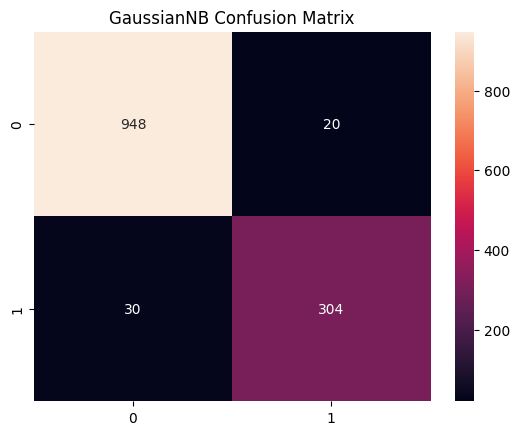

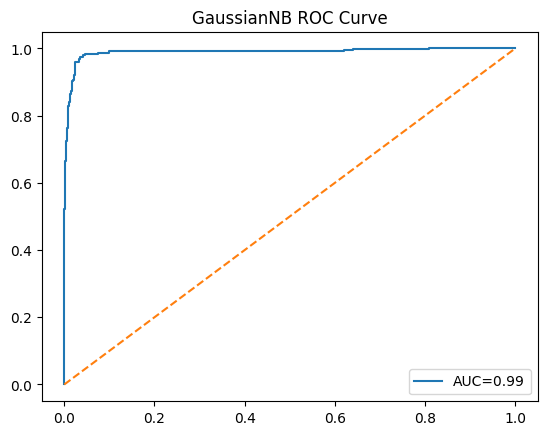

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("GaussianNB Confusion Matrix")
plt.show()

y_prob = gnb.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.title("GaussianNB ROC Curve")
plt.show()


SUPPORT VECTOR MACHINE (SVM)

SVM + GridSearch

In [ ]:
param_grid = {'C':[0.1,1,10], 'gamma':[0.01,0.1,1]}

grid = GridSearchCV(SVC(kernel='rbf', probability=True), param_grid, cv=3)
grid.fit(X_train, y_train)

best_svm = grid.best_estimator_


Accuracy Comparison

In [ ]:
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)

results = pd.DataFrame({
    'Model': ['GaussianNB', 'SVM Linear', 'SVM RBF'],
    'Accuracy': [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, svm_linear.predict(X_test)),
        accuracy_score(y_test, best_svm.predict(X_test))
    ]
})

results


,Model,Accuracy
0,GaussianNB,0.961598
1,SVM Linear,0.999232
2,SVM RBF,0.870968
